In [69]:
import pandas as pd
from sklearn.datasets import load_boston
import os
import pandas as pd
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
np.set_printoptions(precision=3)
from sklearn.model_selection import train_test_split

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import collections
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from random import random, seed
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import Ridge ,LinearRegression, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [70]:
from sklearn.base import RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class Ridge_SVD(RegressorMixin):
    import numpy as np
    from sklearn.metrics import r2_score
    
    def __init__(self, alpha=None):
        
        self.alpha = alpha
        
    def get_params(self, deep=True):
        
        return {'alpha': self.alpha}
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    def fit(self, X, y):
        
        y = np.array(y).ravel()
        X, y = check_X_y(X, y)
        U, singular_values, V_T = np.linalg.svd(X, full_matrices=False)
        n = len(singular_values)
        Sigma_Ridge = np.zeros((n,n))
        Sigma = np.zeros((n,n))
        np.fill_diagonal(Sigma, singular_values)
        np.fill_diagonal(Sigma_Ridge, 1/(singular_values**2+self.alpha))
        #print(f'{V_T.shape}, {Sigma_Ridge.shape}, {Sigma.shape}, {U.T.shape}, {y.shape}')
        self.beta_ =  V_T.T @ Sigma_Ridge @ Sigma @ U.T @ y
        
        return self
    
    def predict(self, X):
        
        check_is_fitted(self)
        X = check_array(X)
        
        return X @ self.beta_
    
    def score(self, X, y):
        
        check_is_fitted(self)
        X = check_array(X)
        
        return r2_score(y, X @ self.beta_)

In [40]:
boston_dataset = load_boston()
boston_features = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston_MEDV = pd.DataFrame(boston_dataset.target, columns=['MEDV'])

In [41]:
frames = [boston_features, boston_MEDV]
boston = pd.concat(frames, axis=1)

In [42]:
boston.shape

(506, 14)

<AxesSubplot:>

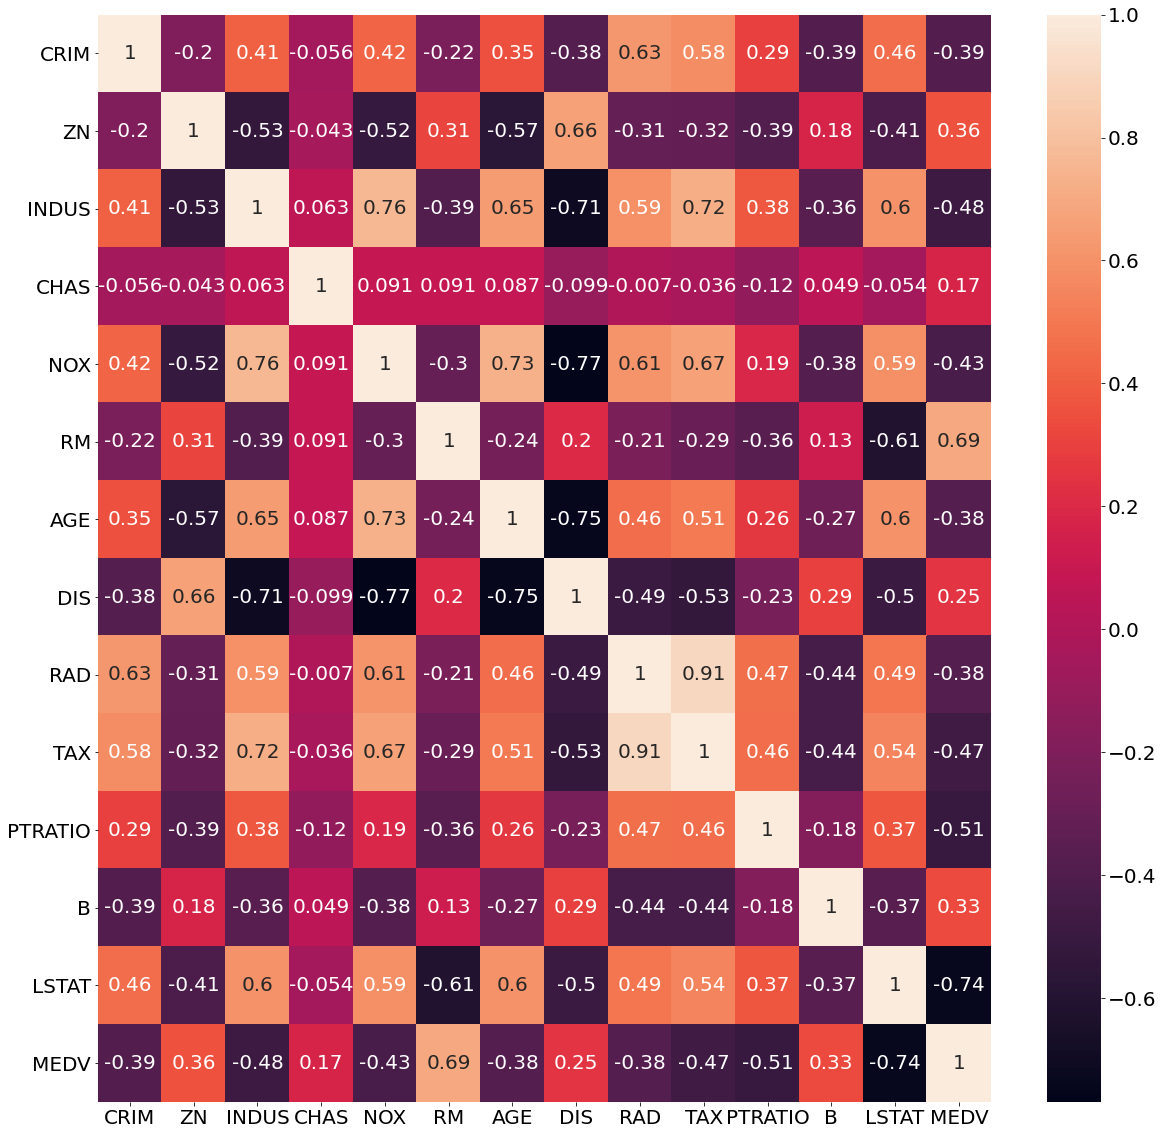

In [44]:
plt.rcParams.update({'font.size': 20})
import seaborn as sns
plt.figure(figsize=(20,20))
corr_matrix = boston.corr().round(3)
sns.heatmap(data=corr_matrix, annot=True)

In [45]:
#PCA through SVD decomposition
boston_df = np.copy(boston)
boston_df -=boston_df.mean(axis=0)
U, singular_values, V_T = np.linalg.svd(boston_df.T.dot(boston_df)/boston_df.shape[0])

In [38]:
categories = boston.columns
variance_initial = np.diag(boston_df.T.dot(boston_df))
print(sorted(variance_initial*100/np.sum(variance_initial), reverse=True))

[73.93616951213838, 21.694943638256763, 2.062469315775534, 1.4158403445399326, 0.2201750145691159, 0.19734621198122326, 0.19258336581363486, 0.13273681070436932, 0.122506391866598, 0.012199998464022132, 0.011541519827124362, 0.0012850005535308838, 0.0001679240449878945, 3.495146477184377e-05]


In [50]:
boston_orth = boston_df.dot(V_T.T)
variance_projected = np.diag(boston_orth.T.dot(boston_orth)/boston_df.shape[0])
print(sorted(variance_projected*100/np.sum(variance_projected), reverse=True))

[80.45721903184202, 16.270557206955523, 2.140832709466097, 0.6957594381020884, 0.20053940071448742, 0.12151466666908933, 0.04441388337138125, 0.035291953835700496, 0.023191283333345945, 0.007083176435914579, 0.0028685137540846685, 0.0005672726078562551, 0.00015384851258215242, 7.614399843549826e-06]


In [68]:
tot_var_initial = np.sum(np.diagonal(boston_df.T.dot(boston_df)/boston_df.shape[0]))
tot_var_projected = np.sum(np.diag(boston_orth.T.dot(boston_orth)/boston_df.shape[0]))                         
np.round(tot_var_initial,3) - np.round(tot_var_projected,3)

0.0

In [53]:
np.sum(np.diag(boston_orth.T.dot(boston_orth)/boston_df.shape[0]))

38342.02364940236

In [54]:
np.sum(np.diagonal(boston_df.T.dot(boston_df)/boston_df.shape[0]))

38342.023649402414

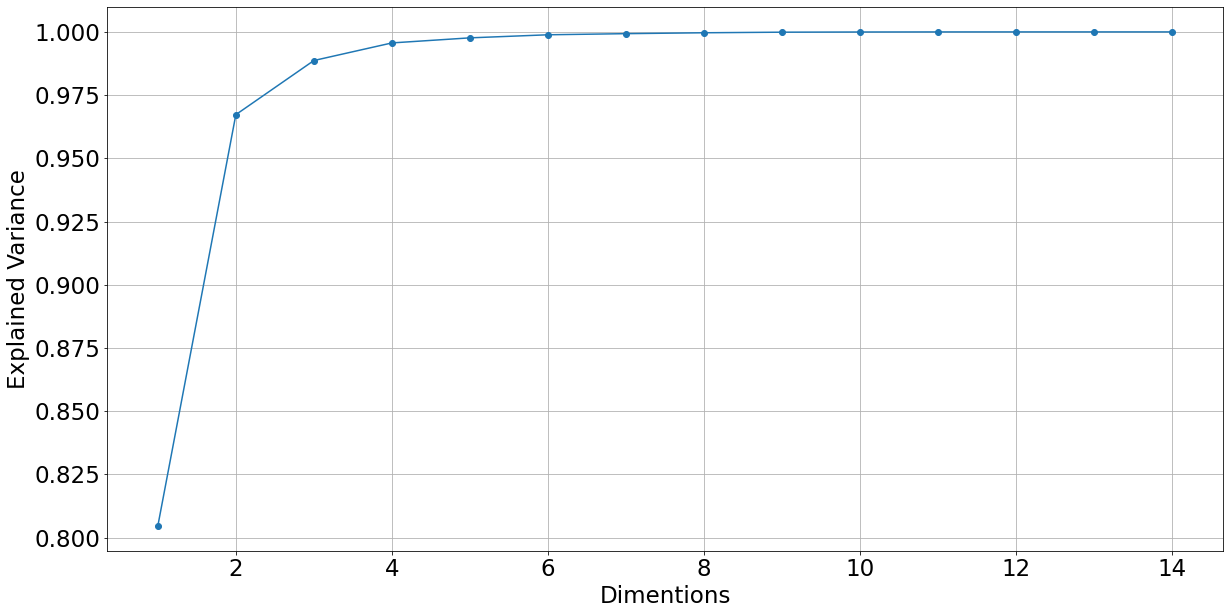

In [34]:
#PCA sklearn
plt.figure(figsize=(20,10))
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(boston_df)
cumsum = np.cumsum(pca.explained_variance_ratio_)
x = np.linspace(1,len(cumsum),len(cumsum))

plt.plot(x, cumsum, 'o-')
plt.xlabel('Dimentions')
plt.ylabel('Explained Variance')
plt.grid()

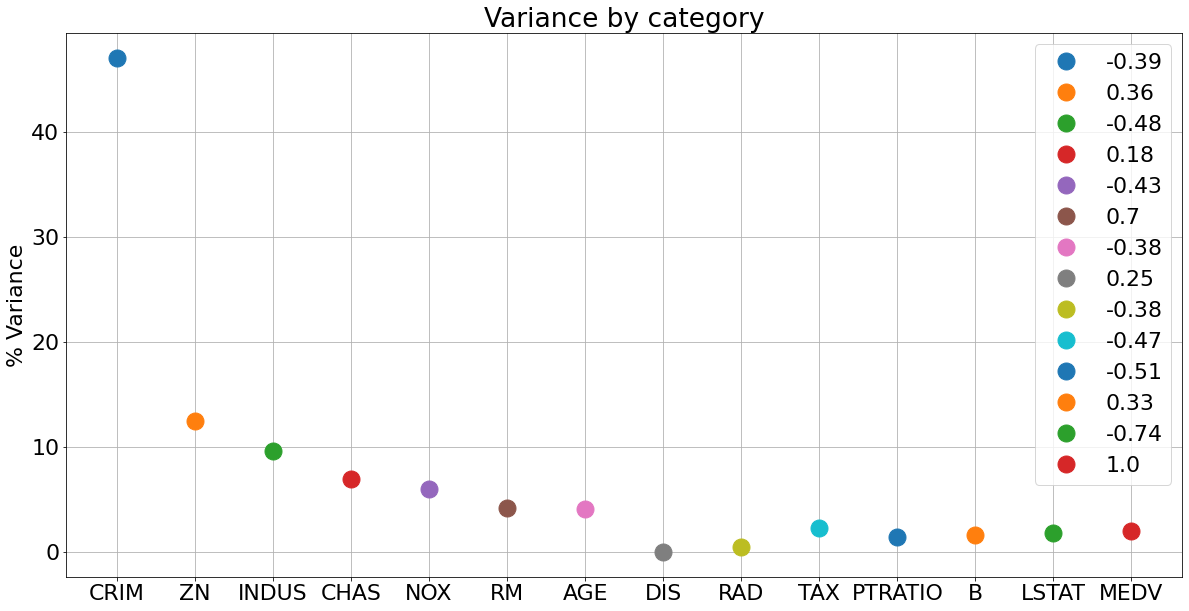

In [52]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size':22})
x = np.arange(1, 15)
for x_, y , corr in zip(x, variance_dascribed, corr_matrix['MEDV']):    
    plt.plot(x_, y, 'o', markersize = 17, label = str(np.round(corr,2)))
plt.ylabel('% Variance')
plt.xticks(x, categories)
plt.legend()
plt.title('Variance by category')
plt.grid()
plt.show()

In [8]:
VIF_all = np.diag(np.linalg.inv(corr_matrix))

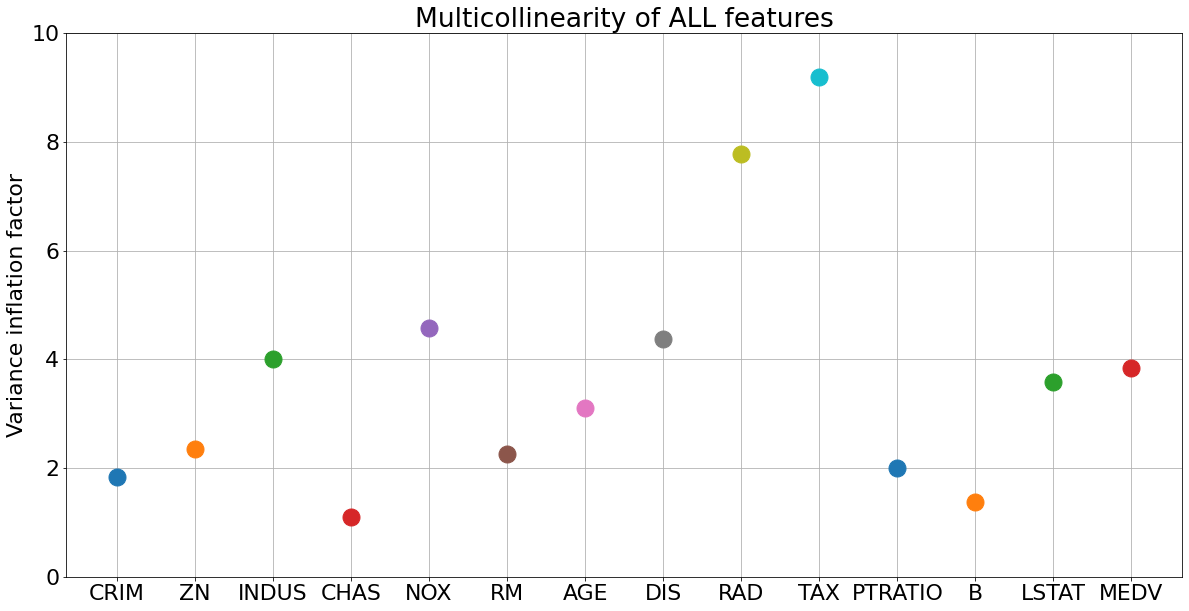

In [9]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size':22})
x = np.arange(1, 15)
for x_, y , corr in zip(x, VIF_all, corr_matrix['MEDV']):    
    plt.plot(x_, y, 'o', markersize = 17)
plt.ylabel('Variance inflation factor')
plt.ylim([0,10])
plt.xticks(x, corr_matrix.columns)
plt.title('Multicollinearity of ALL features')
plt.grid()
plt.show()

In [10]:
#Drop some indecies
to_drop = ['CHAS','RAD']
corr_matrix_cut = boston_df.drop(columns=to_drop).corr()
VIF_cut = np.diag(np.linalg.inv(corr_matrix_cut))

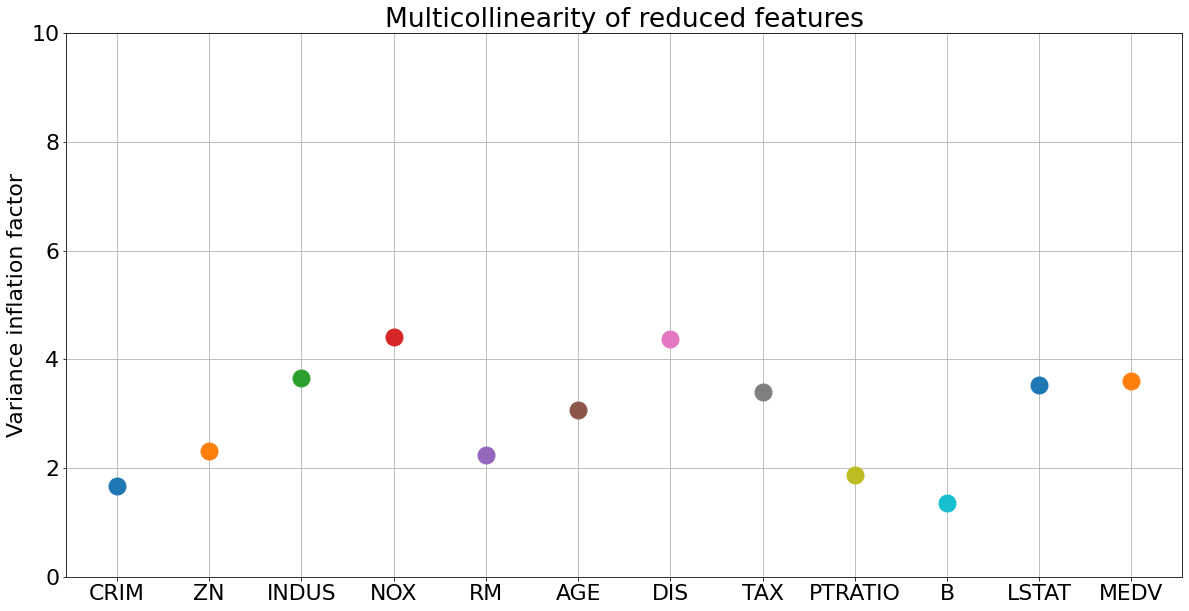

In [11]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size':22})
x = np.arange(1, 13)
for x_, y , corr in zip(x, VIF_cut, corr_matrix_cut['MEDV']):    
    plt.plot(x_, y, 'o', markersize = 17)
plt.ylabel('Variance inflation factor')
plt.ylim([0,10])
plt.xticks(x, corr_matrix_cut.columns)
plt.title('Multicollinearity of reduced features')
plt.grid()
plt.show()

In [12]:
#Linear fit and Ridge
lin_reg = LinearRegression()
degrees = np.arange(1,7)
mse_OLS_train, mse_OLS_test, cv_OLS_train = collections.defaultdict(dict), collections.defaultdict(dict), collections.defaultdict(dict)
r2_OLS_test, r2_OLS_train, cv_OLS_train_std = collections.defaultdict(dict), collections.defaultdict(dict), collections.defaultdict(dict)
scale = StandardScaler()
#Drop some indecies derrived previously
boston_f = boston_features.drop(to_drop, axis=1)
boston_f = scale.fit_transform(boston_f)

for deg in degrees:
    
    #define design matrix
    poly = PolynomialFeatures(degree=deg)
    features = poly.fit_transform(boston_f)
    if features.shape[0] < features.shape[1]:
        print(f'ACHTUNG for degree {deg}: Matrix is underdetermined, dimentionality of feature vector is smaller then dim of column space!!!!')
    #Split train test datasets
    features_train, features_test, target_train, target_test = train_test_split(features, boston_MEDV, test_size=0.2, random_state = 42)
    
    lin_reg.fit(features_train, target_train)
    
    cv_OLS_train[deg] = np.sqrt(np.mean(-cross_val_score(lin_reg, features_train, target_train, cv=10, scoring='neg_mean_squared_error')))
    cv_OLS_train_std[deg] = np.sqrt(np.std(-cross_val_score(lin_reg, features_train, target_train, cv=10, scoring='neg_mean_squared_error')))
    
    r2_OLS_train[deg] = lin_reg.score(features_train, target_train)
    r2_OLS_test[deg] = lin_reg.score(features_test, target_test)
    
    mse_OLS_train[deg] = mean_squared_error(lin_reg.predict(features_train), target_train)
    mse_OLS_test[deg] = mean_squared_error(lin_reg.predict(features_test), target_test)

ACHTUNG for degree 4: Matrix is underdetermined, dimentionality of feature vector is smaller then dim of column space!!!!
ACHTUNG for degree 5: Matrix is underdetermined, dimentionality of feature vector is smaller then dim of column space!!!!
ACHTUNG for degree 6: Matrix is underdetermined, dimentionality of feature vector is smaller then dim of column space!!!!


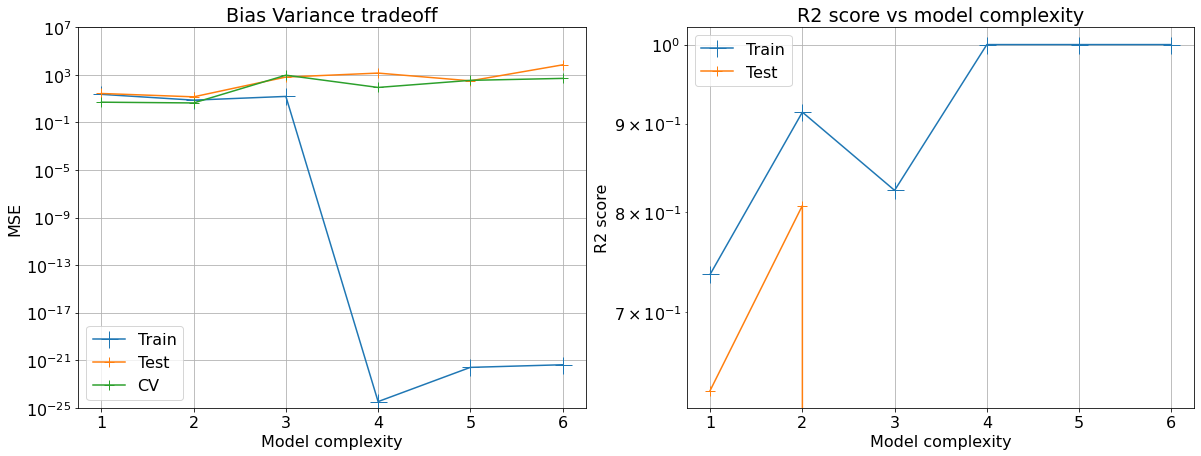

In [13]:
fig = plt.figure(figsize=(20,7))
plt.rcParams.update({'font.size': 16})
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title('Bias Variance tradeoff')
ax1.plot(degrees, np.array(list(mse_OLS_train.values())), '+-', markersize = 17, label = 'Train')
ax1.plot(degrees, np.array(list(mse_OLS_test.values())), '-+', markersize = 10, label = 'Test')
ax1.plot(degrees, np.array(list(cv_OLS_train.values())), '-+', markersize = 10, label = 'CV')
ax1.legend()
ax1.set_xlabel('Model complexity')
ax1.set_ylabel('MSE')
ax1.set_yscale('log')
ax1.set_ylim([1.e-25, 1.e+7])
ax1.grid()

ax2.set_title('R2 score vs model complexity')
ax2.plot(degrees, np.array(list(r2_OLS_train.values())), '+-', markersize = 17, label = 'Train')
ax2.plot(degrees, np.array(list(r2_OLS_test.values())), '-+', markersize = 10, label = 'Test')
ax2.legend()
ax2.set_xlabel('Model complexity')
ax2.set_yscale('log')
ax2.set_ylabel('R2 score')

plt.grid()

plt.savefig(os.path.join('/home/brainy/Documents/ML Erasmus/', 'Scaled_no_features ' + '_'.join(to_drop) + '_BVt_R2_OLS'), format="svg")

In [14]:
#Linear fit and Ridge
lmbds = np.logspace(-4,6,11)
mse_train, mse_test, cv_train, cv_train_std = collections.defaultdict(dict), collections.defaultdict(dict), collections.defaultdict(dict), collections.defaultdict(dict)
r2_test, r2_train = collections.defaultdict(dict), collections.defaultdict(dict)

model_names = ['OLS', 'Ridge', 'Ridge_SVD']

#define design matrix
poly_degree = 2
poly = PolynomialFeatures(degree=2)
features = poly.fit_transform(boston_f)
features = scale.fit_transform(features)
#Split train test datasets
features_train, features_test, target_train, target_test = train_test_split(features, boston_MEDV, test_size=0.2, random_state = 42)

for lmbd in lmbds:
    for model_name, model in zip(model_names, [LinearRegression(), Ridge(alpha=lmbd), Ridge_SVD(alpha=lmbd)]): 
   
        model.fit(features_train, target_train)
        cv_train[model_name][lmbd] = np.sqrt(np.mean(-cross_val_score(model, features_train, target_train, cv=10, scoring='neg_mean_squared_error')))
        cv_train_std[model_name][lmbd] = np.sqrt(np.std(-cross_val_score(model, features_train, target_train, cv=10, scoring='neg_mean_squared_error')))
        r2_test[model_name][lmbd] = model.score(features_test, target_test)
        mse_train[model_name][lmbd] = mean_squared_error(model.predict(features_train), target_train)
        mse_test[model_name][lmbd] = mean_squared_error(model.predict(features_test), target_test)

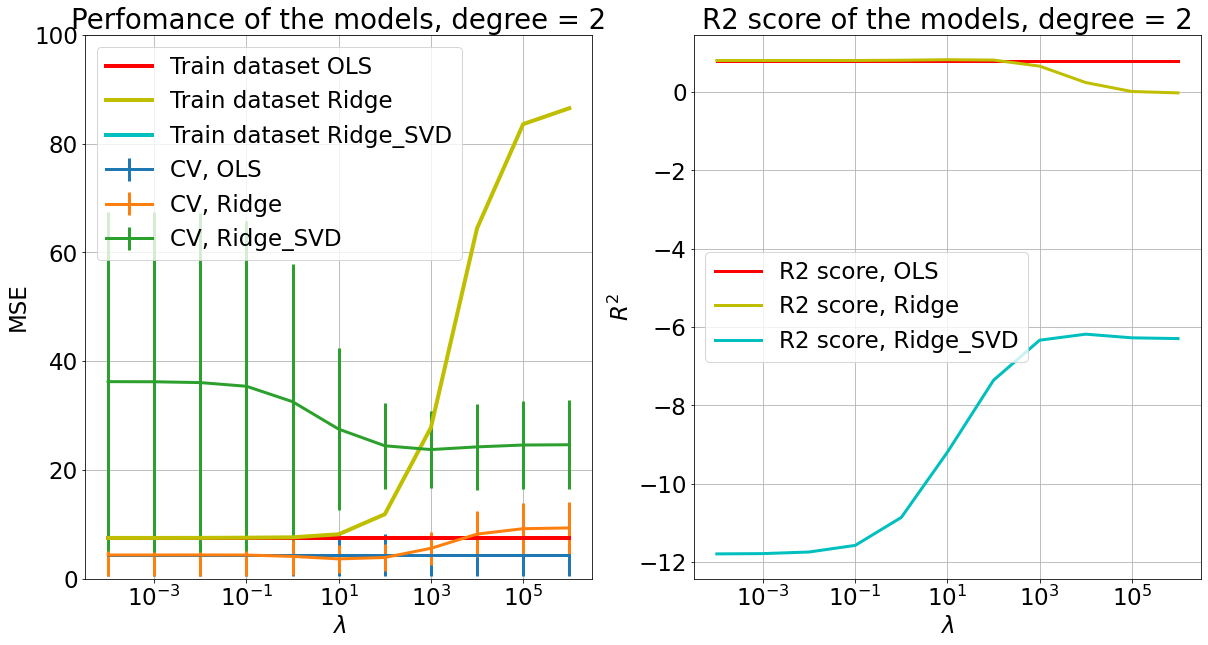

In [17]:
plt.rcParams.update({'font.size': 23})
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

colors = {
    "OLS": "r",
    "Ridge": "y",
    "Ridge_SVD": "c"
}

for model_name in model_names:
    ax1.plot(lmbds, np.array(list(mse_train[model_name].values())), colors[model_name], label=f'Train dataset {model_name}', linewidth=4.0)
    #ax1.semilogx(lmbds, np.array(list(mse_test[model_name].values())), colors[model_name] + "--", label=f'Test dataset {model_name}', linewidth=3.0)
    ax1.errorbar(lmbds, np.array(list(cv_train[model_name].values())), yerr=np.array(list(cv_train_std[model_name].values())), label=f'CV, {model_name}', linewidth=3.0)
    ax2.semilogx(lmbds, np.array(list(r2_test[model_name].values())), colors[model_name], label=f'R2 score, {model_name}', linewidth=3.0)
    
ax1.set_title(f'Perfomance of the models, degree = {poly_degree}')
ax1.legend()
ax1.set_ylim([0,100])
ax1.set_xlabel(r"$\lambda$")
ax1.set_ylabel('MSE')
ax1.set_xscale('log')

ax2.set_title(f'R2 score of the models, degree = {poly_degree}')
ax2.legend()
ax2.set_xlabel(r"$\lambda$")
ax2.set_ylabel(r"$R^2$")

ax1.grid()
ax2.grid()

In [16]:
#Best pefrofmance is OLS with segree 2
print('RMSE +/- std(RMSE) = ', cv_OLS_train[2], '+/-', cv_OLS_train_std[2])

RMSE +/- std(RMSE) =  4.340148755543227 +/- 3.855443129393746


CRIM - per capita crime rate by town
ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
INDUS - proportion of non-retail business acres per town.
CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
NOX - nitric oxides concentration (parts per 10 million)
RM - average number of rooms per dwelling
AGE - proportion of owner-occupied units built prior to 1940
DIS - weighted distances to five Boston employment centres
RAD - index of accessibility to radial highways
TAX - full-value property-tax rate per S10,000
PTRATIO - pupil-teacher ratio by town
B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
LSTAT - % lower status of the population
MEDV - Median value of owner-occupied homes in S1000's